# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Loading the data
The dataset is available in two forms

1. .csv file
2. SQLite Database
In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". 

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
os.chdir('C:/Users/sid/Downloads/apllied courses material/amazon fine food')

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data  = pd.read_sql_query("""
SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""",con)

filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(score):
    if score<3:
        return 'negative'
    return 'positive'



actualscore = filtered_data['Score']
positivenegative = actualscore.map(partition)
filtered_data['Score'] = positivenegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

# Exploratory Data Analysis
# Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#sorting data according to product in ascending order
sorted_data = filtered_data.sort_values("ProductId", axis=0, ascending=True,  inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,positive,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,positive,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,positive,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

# Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


positive    4178
negative     808
Name: Score, dtype: int64

# Text Preprocessing.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [16]:
final['Text'].values[0]

'Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.'

In [17]:
# find sentences containing HTML tags
import re
i =0;
for sent in final['Text'].values:
    if (len(re.findall("<.*?>", sent))):
        print(i)
        print(sent)
        break;
    i+=1;

0
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [18]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('beautiful'))

{'by', 'hadn', 'a', 'don', "hadn't", 'the', 'yourselves', 'against', 'herself', 'weren', 'their', 'theirs', 'during', 'after', "weren't", 'having', 'themselves', 'you', 'he', 'they', "haven't", 'few', 'above', 'all', "shan't", 'more', 'below', "wouldn't", 'hers', 'up', 'nor', 'be', 'them', 'not', 'mustn', 'ourselves', 'no', 'myself', 'in', 'further', 'ma', 'can', "isn't", 'being', 'so', 'here', 'its', "she's", 'do', 'had', "that'll", "aren't", 'me', 'and', 'but', 'why', 'yourself', 'have', 'over', 'before', "mightn't", "you're", 'shouldn', 'm', 'than', 'into', 'too', "needn't", 'both', 'most', 'who', 'as', 'out', 'doesn', 'our', "shouldn't", 'some', 'haven', 'has', 'i', "should've", 'off', 'same', 'shan', 'once', 'hasn', 'because', 'o', 'which', 'd', 'itself', "won't", 'are', 'should', 'between', "didn't", 'to', 've', 'isn', 'these', 'if', "you'd", 'won', 'she', 'that', 'himself', 'an', 'whom', "don't", 'there', 'didn', 'just', "wasn't", 'about', 'for', 'my', "hasn't", "it's", 'when', 

In [19]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1   
            


In [20]:
final['CleanedText']=final_string 
#adding a column of CleanedText which displays the data after pre-processing of the review 

In [21]:
final_string[1500]

b'wow far two review one obvious idea want crispi cooki hey review nobodi good beyond remind look order cooki dont like combin dont order type cooki find combo quit nice realli oatmeal sort calm rich chocol flavor give cooki sort consist let also rememb tast ive given opinion soft chewi cooki advertis crispi cooki blurb would say crispi rather chewi happen like raw cooki howev dont see tast like raw cooki dough soft howev confus yes stick togeth soft cooki tend arent individu wrap would add cost yeah chocol chip cooki tend somewhat sweet want someth hard crisp suggest nabiso ginger snap want cooki that soft chewi tast like combin chocol oatmeal give tri place second order'

In [22]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Featurization
#  BAG OF WORDS

In [23]:
# To get +ve and -ve reviews randomly.

In [24]:
data_pos = final[final['Score']=='positive'].sample(n=2000, replace=True)
data_neg = final[final['Score']=='negative'].sample(n=2000, replace=True)
#Return a random sample of items from an axis of object.
final_4000 = pd.concat([data_pos, data_neg])

In [25]:
final_4000.shape

(4000, 11)

In [26]:
score_4000 = final_4000['Score']

In [27]:
score_4000.shape

(4000,)

In [28]:
#BoW
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#Convert a collection of text documents to a matrix of token counts
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_4000['CleanedText'].values)

In [29]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [30]:
final_counts.get_shape()

(4000, 6243)

# Bi-Grams and n-Grams.

Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin analysis by getting the frequency distribution of the words as shown below

In [31]:
freq_dist_positive = nltk.FreqDist(all_positive_words)
freq_dist_negative = nltk.FreqDist(all_negative_words)
print("Most Common Positive Words: ", freq_dist_positive.most_common(20))
print("Most Common Negative Words :", freq_dist_negative.most_common(20))

Most Common Positive Words:  [(b'like', 1812), (b'tast', 1636), (b'good', 1571), (b'flavor', 1549), (b'love', 1468), (b'great', 1442), (b'use', 1269), (b'product', 1204), (b'one', 1193), (b'tri', 1161), (b'coffe', 1027), (b'food', 1017), (b'chip', 997), (b'make', 982), (b'get', 830), (b'tea', 801), (b'bag', 761), (b'buy', 728), (b'best', 710), (b'eat', 709)]
Most Common Negative Words : [(b'like', 444), (b'tast', 432), (b'product', 399), (b'tri', 282), (b'one', 281), (b'flavor', 271), (b'would', 247), (b'food', 241), (b'use', 231), (b'good', 207), (b'buy', 187), (b'order', 185), (b'tea', 182), (b'chip', 180), (b'bag', 179), (b'get', 179), (b'even', 169), (b'make', 162), (b'box', 161), (b'mix', 155)]


Observation:- From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc.
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [32]:
#bi-gram, tri-gram and n-gram
#removing stop words like "not" should be avoided before building n-grams
# in scikit learn
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect.fit_transform(final_4000['CleanedText'].values)

In [33]:
final_bigram_counts.get_shape()

(4000, 68967)

In [34]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
std_data.shape

(4000, 68967)

In [35]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [36]:
# convert sparse to dense as tsne takes dense vector
std_data = std_data.todense()

In [37]:
type(std_data)

numpy.matrix

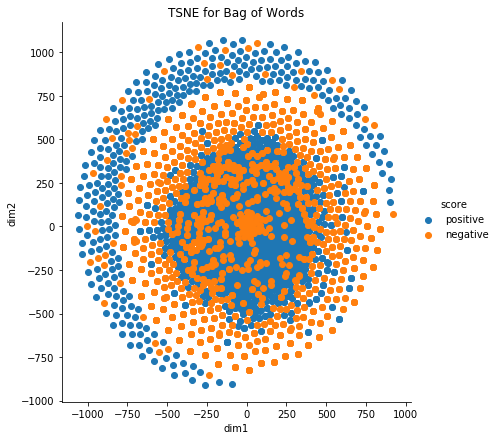

In [38]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

# Observation:- 
Here, we are unable to simply draw a hyperplane and separate +ve and -ve reviews because it overlap each other. But we will have some alternative way to separates review.

# TF-IDF

In [39]:
# Tf-Idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_4000['CleanedText'].values)

In [72]:
type(final_tf_idf)

scipy.sparse.csr.csr_matrix

In [75]:
final_tf_idf.get_shape()

the shape of out text TFIDF vectorizer  (4000, 68967)


In [76]:
final_tf_idf.get_shape()[1]

68967

In [40]:
# Standardization 
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(final_tf_idf)

In [41]:
# Converting sparse matrix to dense because tnse takes dense vector
std_data = std_data.todense()

In [42]:
std_data.shape

(4000, 68967)

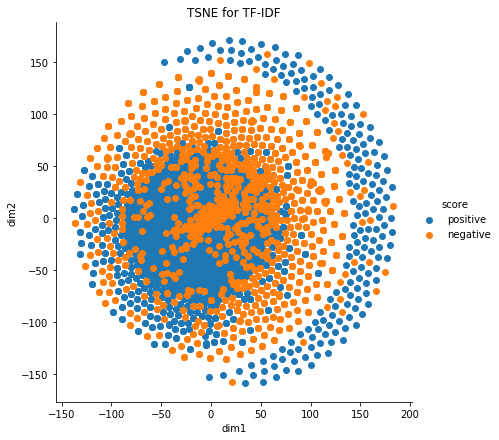

In [43]:
# tsne
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 50)
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

In [44]:
features = tf_idf_vect.get_feature_names()
len(features)

68967

In [45]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 

[0. 0. 0. ... 0. 0. 0.]


In [46]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [47]:
#top_tfidf

# Observations:- 
As this representation also looks like bow and massively overlapped +ve and -ve review.

## Word2Vec

In [48]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file which contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [49]:
# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent = []
for sent in final_4000['Text'].values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [50]:
print(final_4000['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

This product is great.  Just add egg, water, and butter (I used oil).  I will never make waffles from scratch again.
*****************************************************************
['this', 'product', 'is', 'great', 'just', 'add', 'egg', 'water', 'and', 'butter', 'i', 'used', 'oil', 'i', 'will', 'never', 'make', 'waffles', 'from', 'scratch', 'again']


In [51]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=128, workers=4)  

In [52]:
w2v = w2v_model[w2v_model.wv.vocab]

In [53]:
w2v.shape

(3912, 128)

In [67]:
words = list(w2v_model.wv.vocab)
print(len(words))

3912


In [55]:
w2v_model.wv.most_similar('tasty')

[('delicious', 0.9770027995109558),
 ('still', 0.964685320854187),
 ('texture', 0.9636725187301636),
 ('light', 0.9621144533157349),
 ('ok', 0.9579141139984131),
 ('werent', 0.9561781883239746),
 ('salty', 0.9538381099700928),
 ('crunchy', 0.9525434970855713),
 ('runny', 0.9505225419998169),
 ('pretty', 0.9492648839950562)]

In [56]:
w2v_model.wv.most_similar('like')

[('taste', 0.911919891834259),
 ('meh', 0.8953908681869507),
 ('too', 0.8813978433609009),
 ('but', 0.878693163394928),
 ('bitter', 0.8611701726913452),
 ('just', 0.8575621247291565),
 ('describe', 0.8562414646148682),
 ('even', 0.8553478717803955),
 ('tastes', 0.851454496383667),
 ('pretty', 0.843618631362915)]

In [57]:
#count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
#count_vect_feat.index('like')
#print(count_vect_feat[64055])

# Avg W2V, TFIDF-W2V

In [58]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


In [59]:
#sent_vectors = sent_vectors[0:4000]
#len(sent_vectors)

In [70]:
type(sent_vectors)

list

In [87]:
#tsne
#from sklearn.manifold import TSNE
#model = TSNE(n_components=2, random_state=0, perplexity = 20, n_iter = 5000)

#tsne_data = model.fit_transform(sent_vectors)

#tsne_data = np.vstack((tsne_data.T, score_4000)).T
#tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
#sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
#plt.title("TSNE for Average Word2vec")
#plt.show()

In [61]:
# To avoid warnings 
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [63]:
# To know length of tfidf vector
len(tfidf_sent_vectors)

4000

In [64]:
np.isnan(tfidf_sent_vectors)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [65]:
# To replace nan with 0 and inf with large finite number

tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)

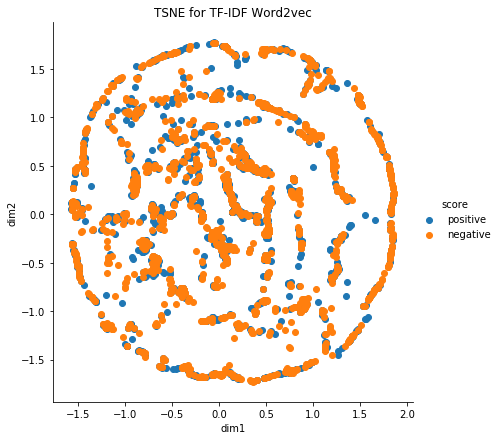

In [66]:
#tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF Word2vec")
plt.show()

# Observation-
This plot also looks like the bow, tfidf and avg word2vec.Both +ve and -ve reviwes are not well seperated they overlapped each other.

# Conclusions:-

AS none of TSNE representation gives a well separated both +ve and -ve reviews.
We can not simply draw a plane to separate -ve and +ve reviews. Although, By looking at only visual representation of data we can not take decision whether to draw a plane or not.
We will have some alternative method by that we will look at into this problem like how we can separate -ve and +ve reviews.